### Load your Libraries

In [ ]:
!pip install xgboost==0.90
!pip install tensorflow
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
# Common Python Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import math
import datetime as dt
import os
import logging
from dateutil.relativedelta import relativedelta
from operator import attrgetter
from datetime import datetime

In [4]:
# Azure Libaries
from azureml.core import Datastore
from azureml.core.dataset import Dataset
from azureml.core.workspace import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication

In [5]:
# XG Boost Libraries # CHANGE HERE TO MATCH YOUR ALGORITHM
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pylab as plt
from matplotlib import pyplot
from collections import Counter

In [6]:
# Tensorflow liba
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)


2.1.0


In [7]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder

### Set Your Workspace

In [8]:
# Check the base version of AzureMl
import azureml.core
print("You are currently using version " + azureml.core.VERSION + " of the Azure ML SDK")

You are currently using version 1.6.0 of the Azure ML SDK


In [9]:
# Retrieve your workspace
ws = Workspace.from_config()

### Set your Datastore

In [10]:
# Retrieve your Datastore
datastore_name = "mlteachingdatastore" # CHANGE HERE
datastore = Datastore.get(ws, datastore_name)

### Set your Datasets

In [11]:
# Retrieve your Datasets by name
df_name  = "auto-mpg-classification-input" # CHANGE HERE


# Load Data in as Tabular Datasets
df_tab  = Dataset.get_by_name(ws, df_name, version='latest')


# Change to pandas dataframe
df = df_tab.to_pandas_dataframe()


In [12]:
df.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9
0,18.0,8,307.0,130,3504,12.0,70,1,"\t""chevrolet chevelle malibu"""
1,15.0,8,350.0,165,3693,11.5,70,1,"\t""buick skylark 320"""
2,18.0,8,318.0,150,3436,11.0,70,1,"\t""plymouth satellite"""
3,16.0,8,304.0,150,3433,12.0,70,1,"\t""amc rebel sst"""
4,17.0,8,302.0,140,3449,10.5,70,1,"\t""ford torino"""


In [13]:
# get rid of the tabs in the last columns
df_column9_dropped = df.drop(['Column9'], axis=1)
df_column9_dropped.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [14]:
# add header row to the dataframe
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
df_column9_dropped.columns = column_names
df_with_headers = df_column9_dropped
df_with_headers.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [15]:
# remove rows with '?' character

df_with_headers = df_with_headers[df_with_headers.Horsepower != '?']
df_with_headers.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


### Prepare Modeling Data

### The "Origin" column is really categorical, not numeric. So convert that to a one-hot:



In [16]:
df_with_headers['Origin'] = df_with_headers['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

df_with_headers.head()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130,3504,12.0,70,USA
1,15.0,8,350.0,165,3693,11.5,70,USA
2,18.0,8,318.0,150,3436,11.0,70,USA
3,16.0,8,304.0,150,3433,12.0,70,USA
4,17.0,8,302.0,140,3449,10.5,70,USA


In [17]:
# generate binary values using get_dummies

# you can use pandas get_dummies to convert categorical variable into dummy/indicator variables.
# or use sklean OneHotEncoder
encoded_df = pd.get_dummies(df_with_headers, columns=["Origin"], prefix=["Origin_is"] )

encoded_df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_is_Europe,Origin_is_Japan,Origin_is_USA
0,18.0,8,307.0,130,3504,12.0,70,0,0,1
1,15.0,8,350.0,165,3693,11.5,70,0,0,1
2,18.0,8,318.0,150,3436,11.0,70,0,0,1
3,16.0,8,304.0,150,3433,12.0,70,0,0,1
4,17.0,8,302.0,140,3449,10.5,70,0,0,1


### Split the data into train and test

In [18]:
train_dataset = encoded_df.sample(frac=0.8,random_state=0)
test_dataset = encoded_df.drop(train_dataset.index)

### Inspect the data 


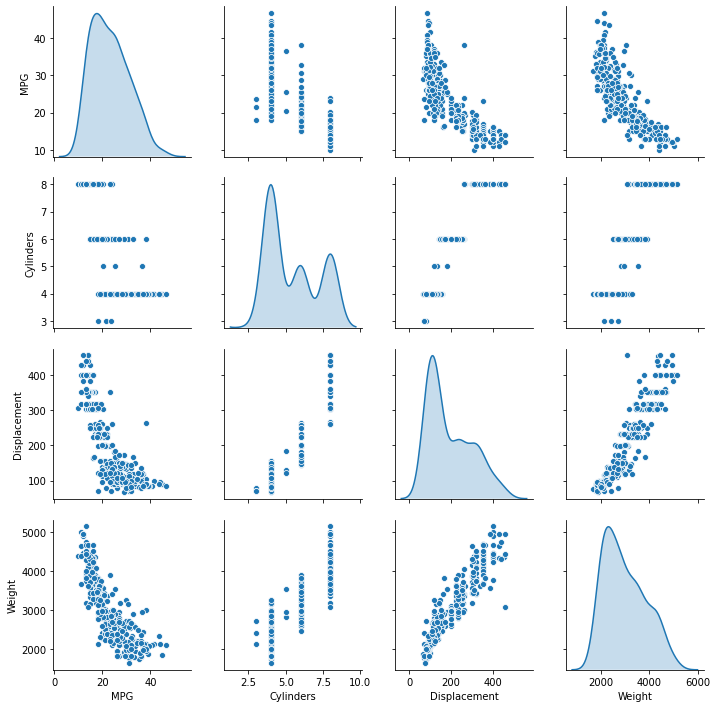

In [19]:
#Have a quick look at the joint distribution of a few pairs of columns from the training set.
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")



In [20]:
#Also look at the overall statistics:

train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.0,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.5,151.0,265.75,455.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.5,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.8,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.0,76.0,79.00,82.0
Origin_is_Europe,314.0,0.178344,0.383413,0.0,0.0,0.0,0.00,1.0
Origin_is_Japan,314.0,0.197452,0.398712,0.0,0.0,0.0,0.00,1.0
Origin_is_USA,314.0,0.624204,0.485101,0.0,0.0,1.0,1.00,1.0


### Separate the features from the target variable(mpg)

In [21]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the dataset

In [22]:

min_max_scaler = preprocessing.MinMaxScaler()


train_dataset[list(train_dataset.columns)] = min_max_scaler.fit_transform(train_dataset[list(train_dataset.columns)])
    



/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Build NN for regression using TF

In [23]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [24]:
model = build_model()

### Inspect the model

In [25]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [26]:
# Train the model for 1000 epochs, and record the training and validation accuracy in the history object.

epochs= 1000

history = model.fit(
  train_dataset, train_labels,
  epochs=epochs, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:588.0604,  mae:22.9976,  mse:588.0604,  val_loss:599.2977,  val_mae:23.1841,  val_mse:599.2977,  
....................................................................................................
Epoch: 100, loss:8.4073,  mae:2.0566,  mse:8.4073,  val_loss:8.1424,  val_mae:2.1998,  val_mse:8.1424,  
....................................................................................................
Epoch: 200, loss:7.5586,  mae:1.9414,  mse:7.5586,  val_loss:8.0658,  val_mae:2.1546,  val_mse:8.0658,  
....................................................................................................
Epoch: 300, loss:7.0579,  mae:1.8994,  mse:7.0579,  val_loss:7.9193,  val_mae:2.1010,  val_mse:7.9193,  
....................................................................................................
Epoch: 400, loss:6.9682,  mae:1.8627,  mse:6.9682,  val_loss:7.4521,  val_mae:2.0417,  val_mse:7.4521,  
..............................................................

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,5.321072,1.572144,5.321072,7.251417,2.033706,7.251417,995
996,5.583311,1.634769,5.583311,7.345382,2.023376,7.345382,996
997,5.533536,1.628415,5.533535,7.559511,2.129048,7.559511,997
998,5.524516,1.619738,5.524515,7.338397,2.061413,7.338398,998
999,5.444609,1.580586,5.444609,7.365656,2.100874,7.365656,999


Text(0, 0.5, 'MAE [MPG]')

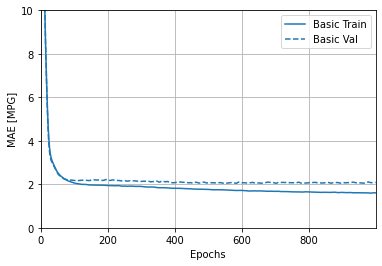

In [29]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')



Text(0, 0.5, 'MSE [MPG^2]')

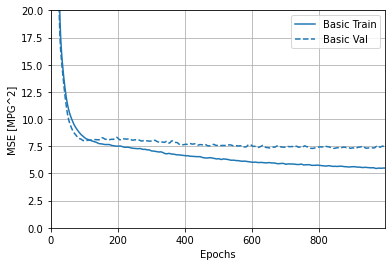

In [30]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [31]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(train_dataset, train_labels, 
                    epochs=epochs, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:570.5653,  mae:22.6283,  mse:570.5653,  val_loss:567.6465,  val_mae:22.5120,  val_mse:567.6465,  
....................................................................................................
Epoch: 100, loss:8.3209,  mae:2.0407,  mse:8.3209,  val_loss:8.0214,  val_mae:2.2090,  val_mse:8.0214,  
......

Text(0, 0.5, 'MAE [MPG]')

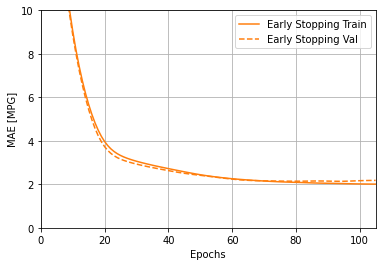

In [32]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [33]:
test_dataset = min_max_scaler.transform(test_dataset)

# df_test[['A','B']] = min_max_scaler.transform(df_test[['A','B']])
# train_dataset[list(train_dataset.columns)] = min_max_scaler.fit_transform(train_dataset[list(train_dataset.columns)])

loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


78/78 - 0s - loss: 5.5089 - mae: 1.7997 - mse: 5.5089
Testing set Mean Abs Error:  1.80 MPG


### Make predictions on test dataset

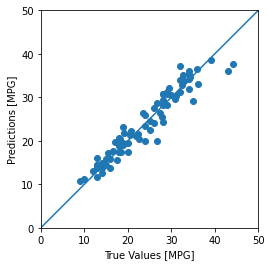

In [34]:
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

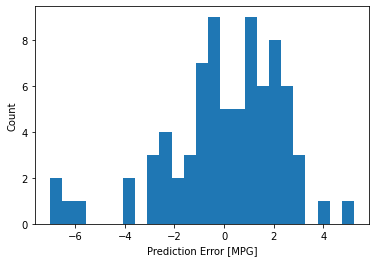

In [35]:
# error dist , the closer to normal dist the better

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")